In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime
import random
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import os

### Specifying path to acess csv file

In [3]:
current_path = os.getcwd()

### Loading our data

In [20]:
# Specify the file path of the CSV file
markets_csv_file_path = current_path+"\\markets.csv"
media_csv_file_path = current_path+"\\media.csv"

# Read the CSV file and create a DataFrame
market_df = pd.read_csv(markets_csv_file_path)
print(market_df.head())

print("###################")

media_df = pd.read_csv(media_csv_file_path)
print(media_df.head())

                        Date       Open       High        Low      Close  \
0  2020-01-02 00:00:00-05:00  67.420502  68.433998  67.324501  68.433998   
1  2020-01-03 00:00:00-05:00  67.400002  68.687500  67.365997  68.075996   
2  2020-01-06 00:00:00-05:00  67.581497  69.916000  67.550003  69.890503   
3  2020-01-07 00:00:00-05:00  70.023003  70.175003  69.578003  69.755501   
4  2020-01-08 00:00:00-05:00  69.740997  70.592499  69.631500  70.251999   

     Volume  Dividends  Stock Splits   AdjClose  
0  27278000        0.0           0.0  68.433998  
1  23408000        0.0           0.0  68.075996  
2  46768000        0.0           0.0  69.890503  
3  34330000        0.0           0.0  69.755501  
4  35314000        0.0           0.0  70.251999  
###################
   Unnamed: 0                   pub_date  word_count type_of_material  \
0          40  2020-01-01 18:00:07+00:00        1040             News   
1          53  2020-01-10 10:00:25+00:00        1368            Op-Ed   
2   

### Adding closest stock price for every article published 

In [21]:
stock_price = []

for pub_time in media_df.pub_date:
    time1 = datetime.datetime.strptime(pub_time, '%Y-%m-%d %H:%M:%S%z')
    price = 0
    initial_time_difference = np.inf
    
    for i in range(len(market_df)):
        
        market_time = market_df.Date[i]
        time2 = datetime.datetime.strptime(market_time, '%Y-%m-%d %H:%M:%S%z')

        # Calculate the time difference
        time_difference = time1 - time2    
        abs_time_difference = abs(time_difference.total_seconds())

        if abs_time_difference<initial_time_difference:
            initial_time_difference = abs_time_difference
            price = market_df.Close[i]
    stock_price.append(price)

media_df["stock_price"]= stock_price

### Ploting the change in sentiment and stock price

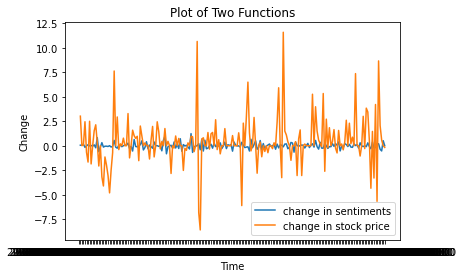

In [37]:
# Create a sample DataFrame with two different functions
m = 0
n = 200

df = pd.DataFrame({
    'x': media_df[0:n].pub_date,
    'function1': media_df[m:n].polarity.diff(),#change in polarity
    'function2': media_df[m:n].stock_price.diff()})#change in stock price

# Plot the two functions on a single plot
plt.plot(df['x'], df['function1'], label='change in sentiments')
plt.plot(df['x'], df['function2'], label='change in stock price')

# Set plot title and labels
plt.title('Plot of Two Functions')
plt.xlabel('Time')
plt.ylabel('Change')

# Add a legend
plt.legend()

# Display the plot
plt.show()

### Pearson Coorelation

Pandas computed Pearson r: 0.03852433443592846
Scipy computed Pearson r: 0.038524334435928495 and p-value: 0.589038656002722


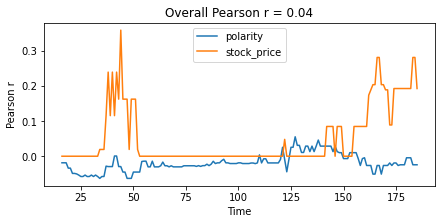

In [25]:
cor_df = pd.merge(media_df[m:n].polarity.diff(),media_df[m:n].stock_price.diff(),left_index=True,right_index=True)

overall_pearson_r = cor_df.corr().iloc[0,1]
print(f"Pandas computed Pearson r: {overall_pearson_r}")

r, p = stats.pearsonr(cor_df.dropna()['polarity'], cor_df.dropna()['stock_price'])
print(f"Scipy computed Pearson r: {r} and p-value: {p}")

# Compute rolling window synchrony
f,ax=plt.subplots(figsize=(7,3))
cor_df.rolling(window=30,center=True).median().plot(ax=ax)
ax.set(xlabel='Time',ylabel='Pearson r')
ax.set(title=f"Overall Pearson r = {np.round(overall_pearson_r,2)}");

### Time lagged Cross Correlation

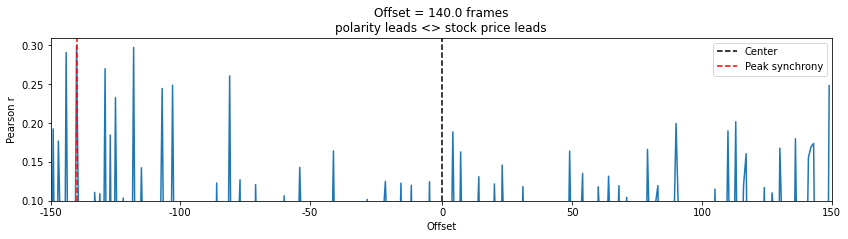

In [39]:
def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))

d1 = cor_df['polarity']
d2 = cor_df['stock_price']
seconds = 5
fps = 30
rs = [crosscorr(d1,d2, lag) for lag in range(-int(seconds*fps),int(seconds*fps+1))]
offset = np.floor(len(rs)/2)-np.argmax(rs)
f,ax=plt.subplots(figsize=(14,3))
ax.plot(rs)
ax.axvline(np.ceil(len(rs)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(rs),color='r',linestyle='--',label='Peak synchrony')
ax.set(title=f'Offset = {offset} frames\npolarity leads <> stock price leads',ylim=[.1,.31],xlim=[0,301], xlabel='Offset',ylabel='Pearson r')
ax.set_xticks([0, 50, 100, 151, 201, 251, 301])
ax.set_xticklabels([-150, -100, -50, 0, 50, 100, 150]);
plt.legend()